In [1]:
import pandas as pd
import json
import jsonlines
from io import StringIO
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import re
import scipy
import numpy as np
import random

# BUILD REDDIT EDGELIST

Using the csv files from RedditHarbor and reusing code from PDS.

In [2]:
submissions = pd.read_csv("../../../data/submission.csv")
comments = pd.read_csv("../../../data/commments.csv")

In [3]:
print("Number of submissions:", submissions.shape[0])
print("Number of comments:", comments.shape[0])

Number of submissions: 320
Number of comments: 5000


Prepare submissions table to merge with comments.

In [4]:
submissions['created_at'] = pd.to_datetime(submissions['created_at'], format='ISO8601')
submissions['body'] = submissions['title'] + " " + submissions['text']
submissions.rename(columns={'submission_id': 'post_id'}, inplace=True)

For ease, we call both submissions and comments posts.

In [5]:
#posts.drop(columns=['link_id', 'parent_id', 'subreddit', 'score', 'edited', 'removed'], inplace=True)
comments['created_at'] = pd.to_datetime(comments['created_at'], format='ISO8601')
comments.rename(columns={'comment_id': 'post_id'}, inplace=True)

In [8]:
posts = pd.concat([comments, submissions], ignore_index=True)
print("Number of posts:", posts.shape[0])

Number of posts: 5320


In [11]:
posts['link_id'] = posts['link_id'].fillna(posts['post_id'])

In [12]:
posts['parent_id_clean'] = posts['parent_id'].str.split('_').str[1]

In [ ]:
# output_file = "../../../data/posts.csv"
# m_posts.to_csv(output_file, index=False)
# print("Saved file to:", output_file)

Merge posts DataFrame with itself to get the redditor_id of the parent_id post

In [18]:
m_posts = posts.merge(posts[['post_id', 'redditor_id']], how='left', left_on='parent_id_clean', right_on='post_id', suffixes=('', '_parent'))

In [21]:
num_nan_redditor_id_parent = m_posts['redditor_id_parent'].isna().sum()
print("Number of rows with NaN in redditor_id_parent:", num_nan_redditor_id_parent)

Number of rows with NaN in redditor_id_parent: 321


In [22]:
num_nan_link_id = m_posts['link_id'].isna().sum()
print("Number of rows with NaN in link_id:", num_nan_link_id)

Number of rows with NaN in link_id: 0


In [23]:
edgelist = m_posts[['redditor_id', 'redditor_id_parent']]

In [24]:
duplicate_rows = edgelist[edgelist.duplicated()]
print("Number of duplicate rows in edgelist:", duplicate_rows.shape[0])

Number of duplicate rows in edgelist: 1843


In [25]:
weighted_edgelist = edgelist.groupby(['redditor_id', 'redditor_id_parent']).size().reset_index(name='weight')

,redditor_id,redditor_id_parent,weight
0,107fal,12o71ik0,1
1,107fal,deleted,1
2,107fal,suspended:ResisteDonc,4
3,109in8,a3n44,1
4,10fbute2,yc8ovgb,1
...,...,...,...
3268,zl7tf,822p1,1
3269,zti3k,ag8kp,1
3270,zvccn,6v0la,1
3271,zvccn,deleted,1


In [26]:
weighted_edgelist = weighted_edgelist[(weighted_edgelist['redditor_id'] != 'deleted') & (weighted_edgelist['redditor_id_parent'] != 'deleted')]
len(weighted_edgelist)

2469

In [27]:
max_weight = weighted_edgelist['weight'].max()
print("Maximum weight in weighted_edgelist:", max_weight)

Maximum weight in weighted_edgelist: 14


In [98]:
output_file = "../../../data/reddit_edgelist.csv"
weighted_edgelist.to_csv(output_file, index=False)
print("Saved file to:", output_file)

Saved file to: ../../../data/reddit_edgelist.csv


In [96]:
weighted_edgelist.head()

,redditor_id,redditor_id_parent,weight
0,107fal,12o71ik0,1
2,107fal,suspended:ResisteDonc,4
3,109in8,a3n44,1
4,10fbute2,yc8ovgb,1
5,10i08v,a3n44,2


In [97]:
weighted_edgelist = weighted_edgelist[['redditor_id_parent', 'redditor_id', 'weight']]
weighted_edgelist.head()

,redditor_id_parent,redditor_id,weight
0,12o71ik0,107fal,1
2,suspended:ResisteDonc,107fal,4
3,a3n44,109in8,1
4,yc8ovgb,10fbute2,1
5,a3n44,10i08v,2


In [187]:
len(weighted_edgelist)

2469

In [189]:
num_pairs_weight_less_than_5 = weighted_edgelist[weighted_edgelist['weight'] < 2].shape[0]
print("Number of pairs with weight less than 5:", num_pairs_weight_less_than_5)

Number of pairs with weight less than 5: 2121


In [99]:
edge_list_tuples = [tuple(x) for x in weighted_edgelist[['redditor_id_parent', 'redditor_id', 'weight']].values]

with open ('reddit.edgelist', 'w') as f:
    for edge in edge_list_tuples:
        f.write(f'{edge[0]} {edge[1]} {edge[2]}\n')

Compute engagement metrics per user

In [38]:
# Step 1: Filter out 'deleted' users and combine unique users from redditor_id and redditor_id_parent
unique_users = pd.concat([m_posts['redditor_id'], m_posts['redditor_id_parent']])
unique_users = unique_users[unique_users != 'deleted'].unique()

# Step 2: Parse the score column to extract score values
def parse_score(value):
    if pd.isna(value) or value == "0":
        return 0
    try:
        score_data = json.loads(value)
        return sum(score_data.values())
    except (json.JSONDecodeError, AttributeError):
        return 0

m_posts['parsed_scores'] = m_posts['score'].apply(parse_score)

# Step 3: Calculate total scores for each unique user
user_scores = m_posts.groupby('redditor_id')['parsed_scores'].sum().reset_index()
user_scores.columns = ['user_id', 'total_scores']

# Filter out 'deleted' users if they exist in the user_scores dataframe
user_scores = user_scores[user_scores['user_id'] != 'deleted']

# Display the result
user_scores.head()


,user_id,total_scores
0,107fal,-4
1,109in8,8
2,10fbute2,1
3,10i08v,2
4,10j9zvrl,32


In [266]:
user_scores_sorted = user_scores.sort_values(by='total_scores', ascending=False)
user_scores_sorted.tail()

,user_id,total_scores
1726,suspended:OHP_Plateau,-72
270,4m897,-73
1833,suspended:timothyjwood,-75
252,4fejvly6,-87
788,bbrbc,-94


In [39]:
max_total_scores = user_scores['total_scores'].max()
print("Maximum total scores:", max_total_scores)

Maximum total scores: 8483


In [50]:
unique_subreddits = submissions['subreddit'].nunique()
print("Number of unique subreddits in submissions:", unique_subreddits)

Number of unique subreddits in submissions: 93


In [52]:
unique_subreddits_list = submissions['subreddit'].unique()
print(unique_subreddits_list)

['lawofone' 'POLACA' 'StrangeEarth' 'thestanleyschool' 'Higherups'
 'quefaitlapolice' 'Seneweb' 'ecologie' 'lostgeneration' 'environment'
 'Anarchism' 'COP21' 'climate' 'france' 'paris' 'IAmA' 'energy'
 'climateskeptics' 'paslegorafi' 'YouShouldKnow' 'collapse'
 'Foodforthought' 'europe' 'conspiracy' 'Quebec' 'unitedkingdom'
 'worldnews' 'transit' 'CommunismWorldwide' 'metacanada' 'canada'
 'CanadaPolitics' 'belgium' 'australia' 'graphic_design' 'Cyberpunk'
 'Denmark' 'SocJus' 'space' 'videos' 'Futurology' 'SandersForPresident'
 'mildlypenis' 'PoliticalDiscussion' 'news' 'AskReddit' 'india'
 'NeutralPolitics' 'LateStageCapitalism' 'geopolitics' 'explainlikeimfive'
 'bestof' 'engineering' 'C_S_T' 'skeptic' 'Documentaries' 'hackernews'
 'GlobalClimateChange' 'aftertheflood' 'effondrement' 'BreakingNews24hr'
 'autotldr' 'PublicBelief' 'newsbotbot' 'UMukhasimAutoNews' 'Lacanau'
 'MAGAWars' 'pinktide' 'capitalocene' 'circular_economy' 'BestOfFrance'
 'okcopainattard' 'ANSAauto' 'BonPote' 'p

In [112]:
output_file = "unique_subreddits_list.txt"
with open(output_file, 'w') as f:
    for subreddit in unique_subreddits_list:
        f.write(f"{subreddit}\n")
print(f"Saved file to: {output_file}")

Saved file to: unique_subreddits_list.txt


In [53]:
min_date = m_posts['created_at'].min()
max_date = m_posts['created_at'].max()

print("Time period in m_posts:")
print("Start date:", min_date)
print("End date:", max_date)

Time period in m_posts:
Start date: 2015-07-18 11:52:16+00:00
End date: 2024-11-13 12:55:44+00:00


# BUILD TWITTER EDGELIST

In [54]:
file_path = '../../../data/tweets.dat'
tweets = []
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        tweet = json.loads(line)
        tweets.append(tweet)
tweets_df = pd.DataFrame(data=tweets) 

In [260]:
len(tweets_df)

2260916

In [65]:
tweets_df['post_day'] = pd.to_datetime(tweets_df['created_at']).dt.strftime('%m/%d/%Y')

In [66]:
replies = tweets_df[tweets_df['in_reply_to_user_id'].notnull()]

In [70]:
replies = replies[replies['lang'].isin(['en', 'fr'])]

In [72]:
replies['like_count'] = replies['public_metrics'].apply(lambda x: x['like_count'])

In [83]:
users=pd.read_csv('../../../data/accounts.tsv',sep='\t')

In [86]:
users['author_id'] = users['author_id'].astype('int64')

In [58]:
unique_types = users['Type'].unique()
print(unique_types)

['Private individuals' 'Advocacy actors' 'Journalistic actors'
 'Political actors' 'Unclear' 'Scientific actors' 'Business actors' 'Bots'
 nan 'Other' 'to-do']


In [79]:
filtered_users = users[~users['Type'].isin(['Unclear', 'Other', 'to-do']) & users['Type'].notna()]
len(filtered_users)

1775

In [88]:
replies['author_id'] = replies['author_id'].astype(str)
users['author_id'] = users['author_id'].astype(str)
replies_type = replies.merge(users, on='author_id', how='left')

In [89]:
num_replies_with_type = replies_type['Type'].notnull().sum()
print("Number of replies with non-null Type:", num_replies_with_type)

Number of replies with non-null Type: 14567


In [91]:
edge_list = replies.groupby(['in_reply_to_user_id', 'author_id']).size().reset_index(name='weight')

In [94]:
edge_list.head()

,in_reply_to_user_id,author_id,weight
0,1000010898,4339043357,2
1,100001781,4339043357,1
2,1000093272,4339043357,1
3,100012166,4339043357,2
4,100012811,4339043357,1


In [95]:
edge_list_tuples = [tuple(x) for x in edge_list[['in_reply_to_user_id', 'author_id', 'weight']].values]

with open ('twitter.edgelist', 'w') as f:
    for edge in edge_list_tuples:
        f.write(f'{edge[0]} {edge[1]} {edge[2]}\n')

In [93]:
output_file = "../../../data/twitter_edgelist.csv"
edge_list.to_csv(output_file, index=False)
print("Saved file to:", output_file)

Saved file to: ../../../data/twitter_edgelist.csv


In [ ]:
# Step 1: Filter out 'deleted' users and combine unique users from author_id and in_reply_to_user_id
unique_users = pd.concat([replies['author_id'], replies['in_reply_to_user_id']])
unique_users = unique_users[unique_users != 'deleted'].unique()

# Step 3: Calculate total like_counts for each unique user
user_like_counts = replies.groupby('author_id')['like_count'].sum().reset_index()
user_like_counts.columns = ['user_id', 'total_like_counts']

# Filter out 'deleted' users if they exist in the user_like_counts dataframe
user_like_counts = user_like_counts[user_like_counts['user_id'] != 'deleted']

# Display the result
user_like_counts.head()

,user_id,total_like_counts
0,100012166,2
1,100028531,0
2,1001283282,1
3,100143392,0
4,100165332,0


In [264]:
user_likes_sorted = user_like_counts.sort_values(by='total_like_counts', ascending=False)
user_likes_sorted.head()

,user_id,total_like_counts
10504,4339043357,13134
1553,14159148,2303
5777,2617471956,1426
11776,5402612,1332
1717,14499829,942


Function to read graphs and get summary:

In [100]:
# reads graph from edgelist with weights
def read_ig(filename):
    rt_edges = []
    with open(filename, "r") as f:
        rt_all=[line.rstrip().split() for line in f]
        rt_edges= [[line[0],line[1],int(line[2])] for line in rt_all]

    rt_network = ig.Graph.TupleList(rt_edges, directed=False, weights=True)
    return rt_network, rt_edges

In [115]:
def summarize_network(r):
    order = r.vcount()
    size = r.ecount()
    components = r.components()
    num_components = len(components)
    size_largest_component = max(components.sizes())
    density = r.density()
    transitivity = r.transitivity_avglocal_undirected()

    print(f"Order: {order}")
    print(f"Size: {size}")
    print(f"Number of components: {num_components}")
    print(f"Size of largest component: {size_largest_component}")
    print(f"Density: {density}")
    print(f"Transitivity (clustering coefficient): {transitivity}")
    
    degrees = r.degree()
    unique_degrees, counts = np.unique(degrees, return_counts=True)

    #print(unique_degrees)
    #print(counts)
    
    plt.loglog(unique_degrees, counts, marker="o", linestyle="None")
    plt.title("Degree Distribution (log-log scale)")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.savefig('degreedist_rep.png')
    plt.show()

# BUILD REDDIT REPLY NETWORK

In [199]:
# Get reply network
print("REPLY NETWORK")
reddit_network, reddit_edges = read_ig("../../../data/reddit.edgelist")
print(reddit_network.summary())

for u in reddit_network.vs:
    if u.degree() == 0:
        print(f"hello what the fuck {u}")

# #reddit_simple = reddit_network.copy()
reddit_simple=reddit_network.simplify(combine_edges=sum)
print(reddit_simple.summary())

ct=0
for u in reddit_simple.vs:
    if u.degree() == 0:
        ct+=1
        #print(f"hello what the fuck {u}")
        reddit_simple.delete_vertices(u)
print(ct)

print(reddit_simple.summary())

REPLY NETWORK
IGRAPH UNW- 1693 2469 -- 
+ attr: name (v), weight (e)
IGRAPH UNW- 1693 1949 -- 
+ attr: name (v), weight (e)
6
IGRAPH UNW- 1687 1949 -- 
+ attr: name (v), weight (e)


Order: 1687
Size: 1949
Number of components: 65
Size of largest component: 1249
Density: 0.0013704688916218574
Transitivity (clustering coefficient): 0.16656506518152667


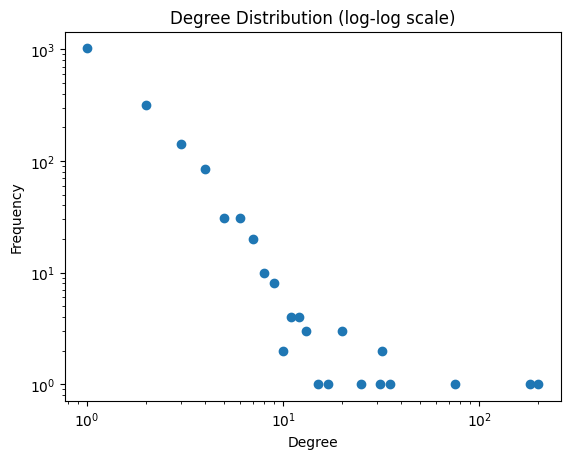

In [200]:
summarize_network(reddit_simple)

id_to_score = dict(zip(user_scores_sorted["user_id"], user_scores_sorted["total_scores"]))

In [281]:
import numpy as np

def prepare_graph(g: ig.Graph, user_scores_sorted, min_size=5, max_size=30):
    layout = g.layout("fr")

    # Map user IDs to total scores
    id_to_score = dict(zip(user_scores_sorted["user_id"], user_scores_sorted["total_scores"]))
    
    # Check if vertex names exist
    if "name" not in g.vs.attributes():
        raise ValueError("The graph vertices do not have a 'name' attribute for matching.")

    # Extract scores for normalization
    scores = [id_to_score.get(v["name"], 0) for v in g.vs]

    # Print to debug scores
    print("Scores:", scores)

    # Logarithmic scaling if score distribution is skewed
    min_score, max_score = min(scores), max(scores)
    print("Min score:", min_score, "Max score:", max_score)

    if min_score != max_score:  # Avoid division by zero
        # Applying logarithmic scaling
        scores_log = [np.log(score + 1) if score > 0 else 0 for score in scores]
        min_log, max_log = min(scores_log), max(scores_log)
        normalized_sizes = [
            min_size + (max_size - min_size) * (score - min_log) / (max_log - min_log)
            for score in scores_log
        ]
    else:
        normalized_sizes = [min_size for _ in scores]  # If all scores are the same

    scaling_factor = 0.3 # Adjust this factor to control the size reduction
    normalized_sizes = [size * scaling_factor for size in normalized_sizes]

    # Print to debug normalized sizes
    print("Normalized sizes:", normalized_sizes)

    # Set vertex properties
    g.vs["color"] = "red"
    g.vs["frame_width"] = 0
    g.vs["label"] = None  # Optionally set labels here if needed
    g.vs["size"] = normalized_sizes

    # Set edge properties
    g.es["color"] = "rgba(0, 0, 0, 0.1)"
    g.es["width"] = 0.05

    return g, layout


In [275]:
import matplotlib.pyplot as plt

def plot_graph(g: ig.Graph, layout: ig.Layout, target_file=None):
    # Visual style configuration
    visual_style = {
        "layout": layout,
        "vertex_color": g.vs["color"],
        "vertex_size": g.vs["size"],
        "vertex_frame_width": 0,
        "vertex_label": g.vs["label"],  # Optionally add labels if desired
        "edge_color": g.es["color"],
        "edge_width": g.es["width"],
        "margin": 2,
        # "bbox": (800, 800),  # Uncomment if you want to control the image size
    }

    # Use matplotlib for plotting
    plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
    ig_plot = ig.plot(g, target=target_file, **visual_style, backend="matplotlib")

    if target_file is None:
        plt.show()  # Show plot interactively
    else:
        print(f"Plot saved to: {target_file}")

In [238]:
reddit_graph, layout = prepare_graph(reddit_simple, user_scores_sorted)

Scores: [75, -4, 15, 1233, 8, 8483, 1, 2, 32, 158, 23, 13, -4, 2617, 1, 100, 41, 2, 35, 8, 18, 4, 740, 4, 435, 2, 8, 14, 2, 64, 18, 13, 32, 2, 1, -7, 3, 304, 0, -15, 0, 16, 4, -5, 6, 37, 1, 92, 1, -11, 44, 3, 5, 5, 8, 8, 33, 21, 8, 107, 1, 2, 6, 1, 13, 7, 2, 2, 17, 2, 2, 10, 2, 1, 4, 84, 1, 61, 363, 1, 1, 109, 5, 24, 1, 71, 10, 2, 174, 11, 6, 36, 1, 1, 38, 75, 68, 19, 2, -7, 4, 1549, 3949, 1, -16, 23, 61, 80, 0, 3, 89, 43, 17, 7, 6, 45, 4, 4, 22, 37, 18, 3, 8, -25, 20, 11, 48, 1, 7, 1, 1, 20, 31, 43, 132, 8, -87, 7, 20, 2, 17, 216, 4, 2, 1, -1, 9, 2, 7, 1, 0, 1, -9, 16, 23, 2, 50, 1, 1, 3, 8, -1, 3, 1, -29, 8, 1, 4333, 3, 103, 1, 1, 74, 5, 17, 3, 27, -13, 3, 20, 38, 5, 23, 11, 33, 72, -13, 9, 5, 53, 7, 4, 7, 29, -75, 30, 1, 6, 0, 15, 3, 20, 1, 10, 11, 2, 28, 95, 20, -2, 13, 6, 6, -3, 38, 15, 434, -1, 3, 2, 2, 0, -32, 3, 40, 36, 5, 3, 26, 2, 3, 2, 14, 6, 10, 12, 1, 75, 14, 5, 14, 26, 11, 3, 9, 30, 46, 9, 0, -10, 3, 5, 1, 25, 4, 30, 14, 46, 5, 238, 2, 3, 1, 2, 3, 9, 1, 1, 4, 19, 77, 9, 6

Plot saved to: reddit_network.png


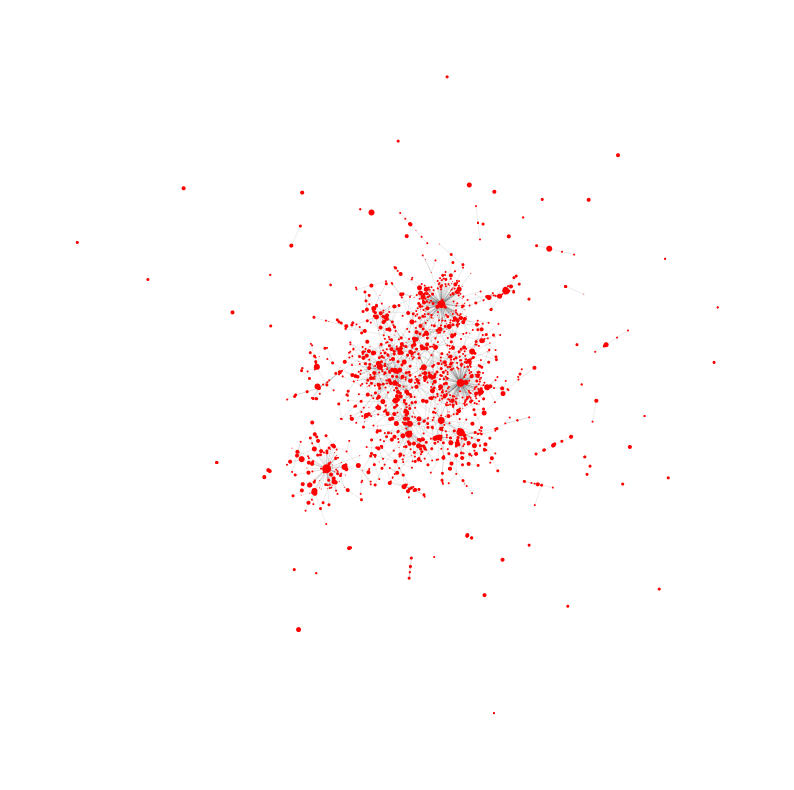

In [209]:
plot_graph(reddit_graph, layout, "reddit_network.png")

user_scores_sorted & user_likes_sorted

In [265]:
user_scores_sorted

,user_id,total_scores
10504,4339043357,13134
1553,14159148,2303
5777,2617471956,1426
11776,5402612,1332
1717,14499829,942
...,...,...
6208,2758258596,0
6209,2758577639,0
6210,27586014,0
6211,275996850,0


In [230]:
type(user_scores_sorted)

pandas.core.frame.DataFrame

In [231]:
user_likes_sorted

,user_id,total_like_counts
10504,4339043357,13134
1553,14159148,2303
5777,2617471956,1426
11776,5402612,1332
1717,14499829,942
...,...,...
6208,2758258596,0
6209,2758577639,0
6210,27586014,0
6211,275996850,0


In [232]:
type(user_likes_sorted)

pandas.core.frame.DataFrame

# BUILD TWITTER REPLY NETWORK

In [118]:
# Get reply network
print("REPLY NETWORK")
twitter_network, twitter_edges = read_ig("../../../data/twitter.edgelist")
print(twitter_network.summary())

for u in twitter_network.vs:
    if u.degree() == 0:
        print(f"hello what the fuck {u}")

#twitter_simple = twitter_network.copy()
twitter_simple=twitter_network.simplify(combine_edges=sum)
print(twitter_simple.summary())

ct=0
for u in twitter_simple.vs:
    if u.degree() == 0:
        ct+=1
        #print(f"hello what the fuck {u}")
        twitter_simple.delete_vertices(u)
print(ct)

print(twitter_simple.summary())

REPLY NETWORK
IGRAPH UNW- 93667 108392 -- 
+ attr: name (v), weight (e)
IGRAPH UNW- 93667 106100 -- 
+ attr: name (v), weight (e)
745
IGRAPH UNW- 92922 106100 -- 
+ attr: name (v), weight (e)


Order: 92922
Size: 106100
Number of components: 1973
Size of largest component: 88649
Density: 2.4576099455454302e-05
Transitivity (clustering coefficient): 0.25589620318637013


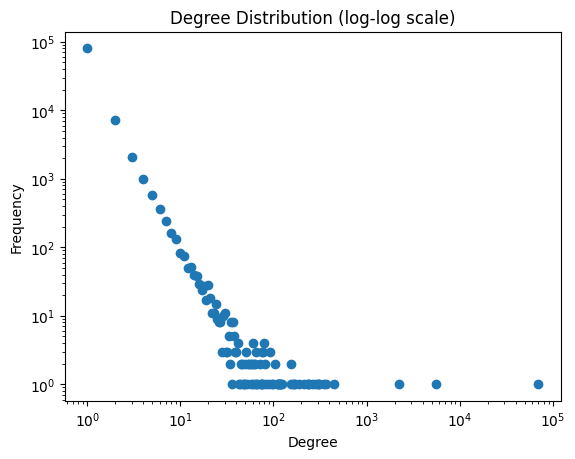

In [119]:
summarize_network(twitter_simple)

In [284]:
reddit_simple, user_scores_sorted = twitter_simple, user_likes_sorted

In [285]:
user_likes_sorted.rename(columns={'total_like_counts': 'total_scores'}, inplace=True)
user_likes_sorted.head()

,user_id,total_scores
10504,4339043357,13134
1553,14159148,2303
5777,2617471956,1426
11776,5402612,1332
1717,14499829,942


In [287]:
twitter_graph, layout = prepare_graph(reddit_simple, user_scores_sorted)

Scores: [0, 13134, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 76, 0, 0, 1, 0, 1, 0, 0, 1426, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 14, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 151, 18, 0, 123, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 5, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 20, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 14, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 

Plot saved to: twitter_simple.png


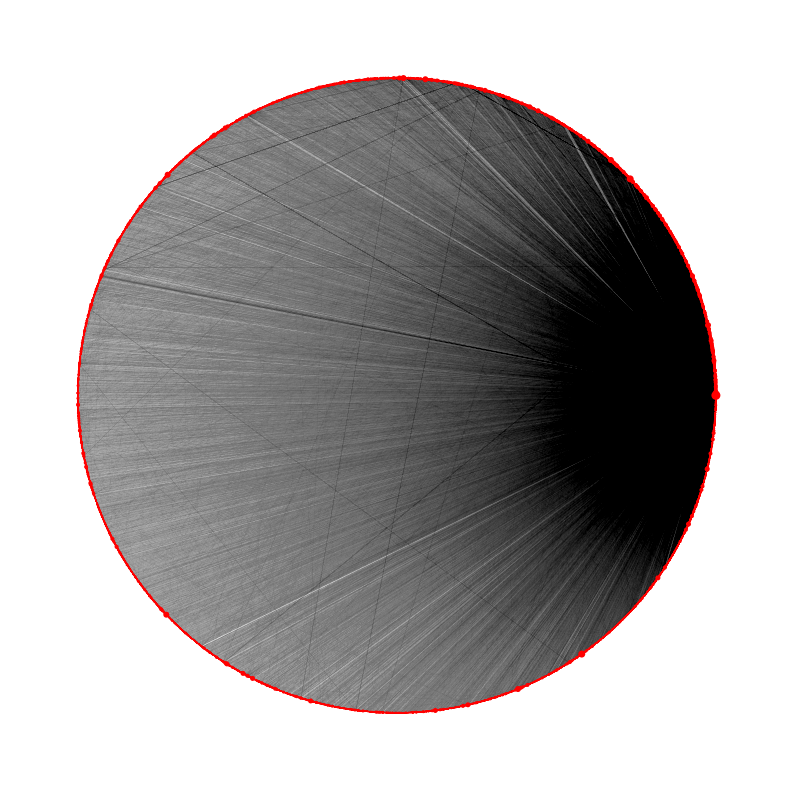

In [258]:
plot_graph(twitter_graph, layout, "twitter_simple.png")

user_likes_sorted & user_scores_sorted

/Users/theodoramoldovan/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/theodoramoldovan/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


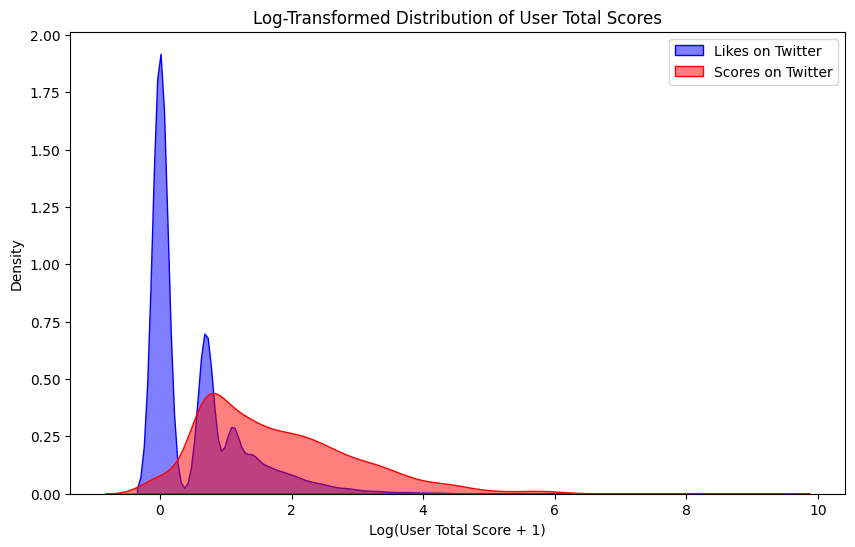

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Log-transform the scores (adding a small constant to avoid log(0))

likes_scores = user_likes_sorted['total_like_counts']
scores_scores = user_scores_sorted['total_scores']

likes_scores_normalized_log = np.log1p(likes_scores)
scores_scores_normalized_log = np.log1p(scores_scores)

# Plot the distributions
plt.figure(figsize=(10, 6))

sns.kdeplot(likes_scores_normalized_log, color='blue', label='Likes on Twitter', fill=True, alpha=0.5)
sns.kdeplot(scores_scores_normalized_log, color='red', label='Scores on Twitter', fill=True, alpha=0.5)

plt.title('Log-Transformed Distribution of User Total Scores')
plt.xlabel('Log(User Total Score + 1)')
plt.ylabel('Density')
plt.legend()

plt.show()
